In [1]:
import os
import time

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torch.nn.functional as F
import math
from torch import nn, Tensor, TupleType
from torch.nn import Transformer
from torch.nn import LSTM

from torch.utils.data import TensorDataset, DataLoader, Dataset, random_split
from torch.autograd import Variable
from tqdm import tqdm
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.model_selection import train_test_split  

device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

In [2]:
mm_scaler = MinMaxScaler()

class StrideDataset(Dataset):
    def __init__(self, file_path, enc_seq_len, target_seq_len, x_size, stride=5):
        df = pd.read_csv(file_path)
        
        self.soc = df.iloc[x_size:, 20:21].values #SoC
        self.soc = self.soc.squeeze()
        self.soc = mm_scaler.fit_transform(self.soc.reshape(-1, 1))
        self.soc = self.soc.squeeze()

        self.src_v = df.iloc[x_size:, 7:8].values #V
        self.src_v = self.src_v.squeeze()
        self.src_v = mm_scaler.fit_transform(self.src_v.reshape(-1, 1))
        self.src_v = self.src_v.squeeze()

        self.src_c = df.iloc[x_size:, 6:7].values #I
        self.src_c = self.src_c.squeeze()
        self.src_c = mm_scaler.fit_transform(self.src_c.reshape(-1, 1))
        self.src_c = self.src_c.squeeze()


        self.length = len(df) - x_size

        num_samples = (self.length - enc_seq_len - target_seq_len) // stride + 1 #stride씩 움직일 때 생기는 총 sample 개수
        
        src_v = np.zeros([enc_seq_len, num_samples])
        src_c = np.zeros([enc_seq_len, num_samples])
        trg = np.zeros([target_seq_len, num_samples])

        
        for i in np.arange(num_samples):
            start_x = stride*i
            end_x = start_x + enc_seq_len
            src_v[:,i] = self.src_v[start_x:end_x]
            src_c[:,i] = self.src_c[start_x:end_x]

            start_y = stride*i + enc_seq_len
            end_y = start_y + target_seq_len
            trg[:,i] = self.soc[start_y:end_y]

        src_v = src_v.reshape(src_v.shape[0], src_v.shape[1], 1).transpose((1,0,2))
        src_c = src_c.reshape(src_c.shape[0], src_c.shape[1], 1).transpose((1,0,2))
        trg = trg.reshape(trg.shape[0], trg.shape[1], 1).transpose((1,0,2))

        self.src_v = src_v
        self.src_c = src_c
        self.trg = trg

        self.len = len(src_v)

    def __getitem__(self, i):
        return self.src_v[i], self.src_c[i], self.trg[i, :-1], self.trg[i, 1:]
    
    def __len__(self):
        return self.len

In [3]:
train_dataset_1 = StrideDataset("FUDS_80.csv", 50, 20, 2586, stride=5)


a = torch.tensor(train_dataset_1.src_v, dtype=torch.float32)

In [4]:
a = a.transpose(1,2)

cnn_in1 = nn.Conv1d(1, 1, kernel_size=5,stride=3)
cnn_in2 = nn.Conv1d(1, 1, kernel_size=5, stride=3)
li1 = nn.Linear(4, 35)
li2 = nn.Linear(35, 50)



out = cnn_in1(a)
out = cnn_in2(out)
out = li1(out)
out = li2(out)


print(out.shape)



torch.Size([2206, 1, 50])


In [5]:
# fil = np.array([0.2,0.2,0.2,0.2,0.2])
# a = a.squeeze()
# a = a.contiguous().view(-1)
# print(a.shape)
# a = np.convolve(a,fil,mode='same')

In [6]:
out = out.view(-1)
print(out.shape)
print(out.dtype)

torch.Size([110300])
torch.float32


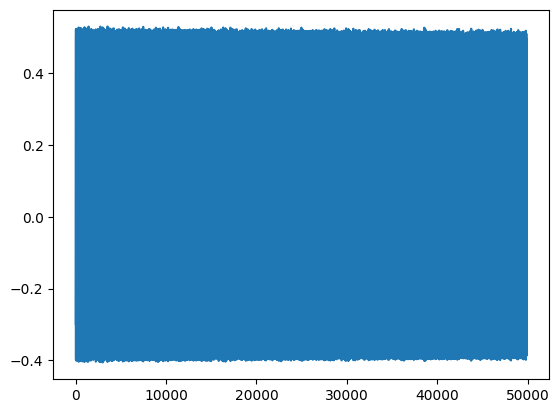

In [7]:
plt.plot(out.detach().numpy()[100:50000])

torch.Size([2206, 50, 1])
torch.Size([2206, 1, 50])
torch.Size([110300])


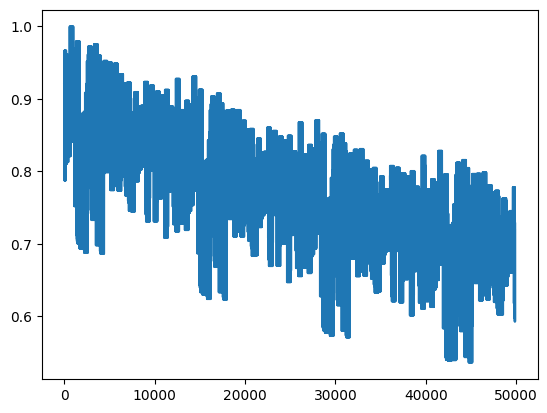

In [8]:
ori = torch.tensor(train_dataset_1.src_v, dtype=torch.float32)
print(ori.shape)
ori = ori.transpose(1,2)
print(ori.shape)
ori = ori.contiguous().view(-1)
print(ori.shape)



plt.plot(ori.view(-1)[100:50000])